In [1]:
# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

from skimage.filters import scharr
from skimage.util.shape import view_as_blocks
import matplotlib.animation as animation
plt.gray()

In [2]:
def disp_histogram(data):
    n_bins=int(data.max()+1)
    plt.hist(data.ravel(), normed=True, bins=n_bins, range=(0, n_bins),
                       facecolor='0.5')
    plt.show()

In [3]:
cap = cv2.VideoCapture('/usagers2/jusimc/travail/Downloads/aic19-track3-train-data/74.mp4')
i = 0
ppc = 8
n_frames = int(cap.get(7))
max_frames = n_frames

rows = int(cap.get(4)) 
cols = int(cap.get(3))
n_blocks_row = rows // ppc
n_blocks_col = cols // ppc
#fps = int(cap.get(5))
fps=300
nb_frames = max_frames//fps + 1
fds = np.zeros((int(cap.get(4)), int(cap.get(3)), nb_frames))
#while(cap.isOpened()):
print(max_frames//fps + 1)

90


In [4]:
j=0
while i < max_frames:
    ret, image = cap.read()
    if i%fps == 0:
        img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        fd = scharr(img_gray)
        fds[:,:,j] = fd
        j+=1
    i+=1
    print('\r',  (i/max_frames)*100 , end='')

cap.release()

 100.0627143922446656449.116331096196866

In [5]:
offx = rows % ppc
offy = cols % ppc
test = view_as_blocks(fds[:rows-offx,:cols-offy, :], block_shape=(ppc, ppc, nb_frames)).squeeze()
print(test.shape)

(51, 100, 8, 8, 90)


[0. 0. 0. ... 0. 0. 0.]


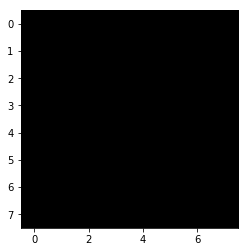

In [6]:
res = (test[:,:,:,:,:]*255).ravel()
print(res)
#disp_histogram(res)
plt.imshow(test[0,0,:,:,0]*255)

In [7]:
# Let's try to display magnitudes
magnitudes = np.zeros((n_blocks_row, n_blocks_col, nb_frames))
ims = []
for t in range(nb_frames):
    for i in range(n_blocks_row):
        for j in range(n_blocks_col):
            magnitudes[i,j,t] = np.sum(test[i,j,:,:,t])
    #plt.matshow(magnitudes[:,:,t], cmap=plt.cm.viridis)
    #plt.savefig("mag/"+str(t)+".png")

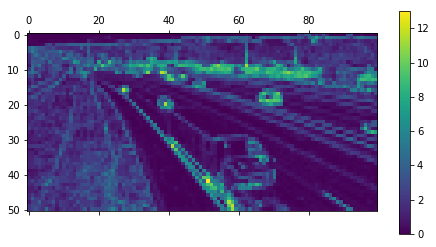

In [8]:
plt.matshow(magnitudes[:,:,0], cmap=plt.cm.viridis)
plt.colorbar()

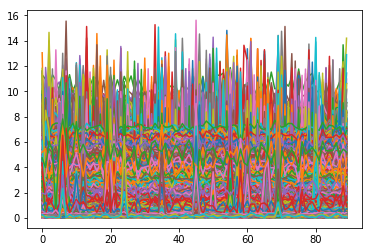

In [9]:
# Let's plot the magnitudes through time
for i in range(n_blocks_row):
    for j in range(n_blocks_col):
        plt.plot(range(nb_frames), magnitudes[i,j,:])
plt.show()
# On veut un filtre passe bande (0.0001Hz; 0.5Hz)
# Ou uniquement les signaux avec des grands pics

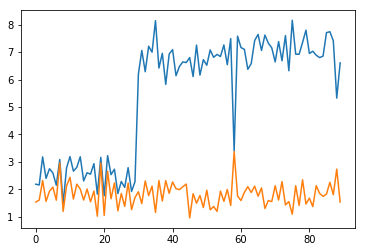

In [10]:
plt.plot(range(nb_frames), magnitudes[15,20,:])
plt.plot(range(nb_frames), magnitudes[19,20,:])

In [13]:
def get_peak(signal, p = False):
    signal -= np.average(signal)
    step = np.hstack((np.ones(len(signal)), -1*np.ones(len(signal))))
    signal_step = np.convolve(signal, step, mode='valid')
    # get the peak of the convolution, its index
    step_indx = np.argmax(signal_step)  # yes, cleaner than np.where(dary_step == dary_step.max())[0][0]
    #plots
    if p:
        plt.plot(signal)
        plt.plot(signal_step/10)
        plt.plot((step_indx, step_indx), (signal_step[step_indx]/10, 0), 'r')
    return signal_step[step_indx]

"\npeaks = np.zeros((n_blocks_row, n_blocks_col))\n# Let's plot the magnitudes through time\nfor i in range(n_blocks_row):\n    for j in range(n_blocks_col):\n        peaks[i,j] = get_peak(magnitudes[i,j,:])\n"

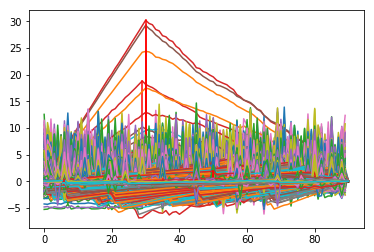

In [17]:
peaks = np.zeros((n_blocks_row, n_blocks_col))
# Let's plot the magnitudes through time
for i in range(n_blocks_row):
    for j in range(n_blocks_col):
        peaks[i,j] = get_peak(magnitudes[i,j,:])

174.71796179197747

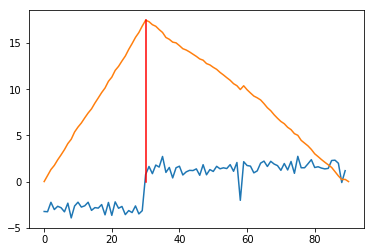

In [16]:
get_peak(magnitudes[15,20,:])

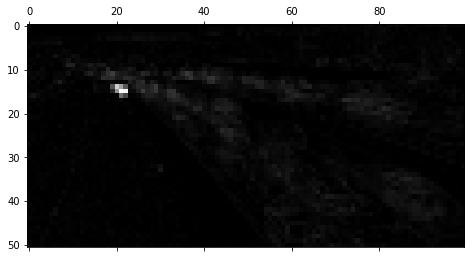

In [18]:
plt.matshow(peaks)

In [ ]:
print(magnitudes.shape)
print(test.shape)
print(test[i,j,:,:].T.shape)
flatten_view = test.reshape(test.shape[0], test.shape[1], -1)
print(flatten_view.shape)

In [ ]:
# Outlier detection
from pyod.models.iforest import IForest
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF


clf = IForest(n_estimators = 100,
             max_samples = 1000,
             contamination = 0.01,
             max_features = ppc * ppc,
             n_jobs = -1)


"""
clf = ABOD(contamination = 0.005,
          n_neighbors = 30,
          method = 'fast')
"""

preds = {}
preds_map = np.zeros((n_blocks_row, n_blocks_col))
for i in range(n_blocks_row):
    for j in range (n_blocks_col):
        data = test[i,j,:,:].T
        data = data.reshape(data.shape[0], -1)
        clf.fit(data)
        preds[(i,j)] = np.argwhere(clf.predict(data) == 1).ravel()
        preds_map[i,j] = len(preds[(i,j)])
        

In [ ]:
plt.imshow(preds_map)

In [ ]:
res = [x for y in list(preds.values()) for x in y]
print(len(res))
unique, counts = np.unique(res, return_counts=True)
res2 = dict(zip(unique, counts))
res2

In [ ]:
tmp = [x for x in res2.keys()]
plt.bar(tmp, res2.values(), 1)


In [ ]:
means = np.zeros((n_blocks_row, n_blocks_col))
varis = np.zeros((n_blocks_row, n_blocks_col))
for i in range(n_blocks_row):
    for j in range (n_blocks_col):
        means[i,j] = np.mean(test[i,j,:,:])
        varis[i,j] = np.var(test[i,j,:,:])

In [ ]:
plt.matshow(means)
plt.show()
plt.matshow(varis)
plt.show()

In [ ]:
import skimage.measure
res = skimage.measure.block_reduce(varis, (2,2), np.min)
#plt.matshow(res)

kernel = np.ones((3,3),np.uint8)
erosion = cv2.erode(varis,kernel,iterations = 1)
plt.matshow(erosion)
#plt.matshow(erosion >= np.max(erosion))

In [ ]:
# Here let's look at the difference of gradients
diffs = np.abs(np.diff(fds, axis=2))

In [ ]:
plt.matshow(diffs[:,:,0])
print(diffs.shape)

In [ ]:
offx = rows % ppc
offy = cols % ppc
test2 = view_as_blocks(diffs[:rows-offx,:cols-offy, :], block_shape=(ppc, ppc, nb_frames-1)).squeeze()
print(test2.shape)

In [ ]:
means = np.zeros((n_blocks_row, n_blocks_col))
varis = np.zeros((n_blocks_row, n_blocks_col))
for i in range(n_blocks_row):
    for j in range (n_blocks_col):
        means[i,j] = np.mean(test2[i,j,:,:])
        varis[i,j] = np.var(test2[i,j,:,:])

In [ ]:
plt.matshow(means)
plt.show()
plt.matshow(varis)
plt.show()

In [ ]:
norm_means = 1-(means / np.max(means))
norm_means = np.power(norm_means, 1)
plt.matshow(norm_means)

In [ ]:
plt.matshow(np.multiply(norm_means, varis))

In [ ]:
# Prochaines taches:
# Tester l'idée des poids
# Tester l'idée du filtrage de signaux
# Essayer de générer les frames anormales